<a href="https://colab.research.google.com/github/josephxlp/SHORT_PROJECTS/blob/main/CropHealthTAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install rasterio rasterstats -q

In [37]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [38]:
datapath= "/content/drive/MyDrive/PROJx/data/GeoML/crop_data/"
os.chdir(datapath)

In [39]:
# Open the raster files using context managers
with rasterio.open('data/dem.tif') as dem, \
     rasterio.open('data/ortho.tif') as ortho, \
     rasterio.open('data/dtm.tif') as dtm:

    # Read the data into arrays
    dem_arr = dem.read(1)
    ortho_arr = ortho.read([1, 2, 3, 4, 5, 6])  # R, G, B, NIR, RedEdge, Thermal
    dtm_arr = dtm.read(1)


In [40]:
plots_1 = gpd.read_file('data/plots_1.shp')
plots_2 = gpd.read_file('data/plots_2.shp')

In [41]:
elevation = np.where(dem_arr <= 0, np.nan, dem_arr)
masked_thermal = np.where(ortho_arr[5] <= 0, np.nan, ortho_arr[5] / 100 - 273.15)  # Convert to Celsius

In [42]:
# Generate NDVI (Normalized Difference Vegetation Index) with error handling
# NDVI = (NIR - Red) / (NIR + Red)
with np.errstate(divide='ignore', invalid='ignore'):
    ndvi = (ortho_arr[3] - ortho_arr[0]) / (ortho_arr[3] + ortho_arr[0])
    ndvi = np.where(np.isnan(ndvi), 0, ndvi)

In [43]:
def compute_zonal_stats(plots, data, affine):
    import rasterstats as rs
    plot_zs = rs.zonal_stats(plots, data, affine=affine, stats="mean", nodata=np.nan, geojson_out=True)
    return gpd.GeoDataFrame.from_features(plot_zs)

In [44]:
# Calculate mean NDVI, thermal, elevation, and DTM values for each plot
plots_1['NDVI_mean'] = compute_zonal_stats(plots_1, ndvi, dem.transform)['mean']
plots_1['thermal_mean'] = compute_zonal_stats(plots_1, masked_thermal, dem.transform)['mean']
plots_1['elevation_mean'] = compute_zonal_stats(plots_1, elevation, dem.transform)['mean']
plots_1['dtm_mean'] = compute_zonal_stats(plots_1, dtm_arr, dem.transform)['mean']

In [45]:
plots_1.head()

,NAME,LAYER,MAP_NAME,geometry,NDVI_mean,thermal_mean,elevation_mean,dtm_mean
0,2,Coverage/Quad,User Created Features,"POLYGON Z ((289583.708 5130289.226 0, 289588.7...",0.438559,28.059842,363.717766,362.185250
1,3,Coverage/Quad,User Created Features,"POLYGON Z ((289588.705 5130289.052 0, 289593.7...",0.445282,26.597221,363.811965,362.165315
2,4,Coverage/Quad,User Created Features,"POLYGON Z ((289593.702 5130288.877 0, 289598.6...",0.552864,27.543570,364.005800,362.121171
3,5,Coverage/Quad,User Created Features,"POLYGON Z ((289598.699 5130288.703 0, 289603.6...",0.530295,24.495659,365.031981,362.062528
4,6,Coverage/Quad,User Created Features,"POLYGON Z ((289603.696 5130288.528 0, 289608.6...",0.536660,23.950518,365.145092,361.989222


In [46]:
# Data preparation
# Drop NaN values and prepare feature matrix for model training
plots_1 = plots_1.dropna()
features = plots_1[['NDVI_mean', 'thermal_mean', 'elevation_mean', 'dtm_mean']]

In [47]:
# Create a synthetic target variable focusing on healthy crops
# Define healthy crops based on NDVI values between 0.4 and 0.8
healthy_mask = (plots_1['NDVI_mean'] >= 0.4) & (plots_1['NDVI_mean'] <= 0.8)
plots_1['synthetic_target'] = np.where(healthy_mask, 1, 0)  # Healthy crops = 1, Others = 0

In [48]:
# Check data balance
# Print class distribution to check for imbalance
class_counts = plots_1['synthetic_target'].value_counts()
print(f"Class distribution:\n{class_counts}")

# Handle data imbalance by undersampling the majority class
from sklearn.utils import resample

# Separate majority and minority classes
# This variable indicates whether a crop is healthy (1) or not (0).
minority_class = plots_1[plots_1['synthetic_target'] == 1]
majority_class = plots_1[plots_1['synthetic_target'] == 0]

# Resample majority class to match the minority class size
majority_class_downsampled = resample(majority_class,
                                      replace=False,
                                      n_samples=len(minority_class),
                                      random_state=42)
balanced_data = pd.concat([minority_class, majority_class_downsampled])

# Reassign features and target from the balanced data
features = balanced_data[['NDVI_mean', 'thermal_mean', 'elevation_mean', 'dtm_mean']]
target = balanced_data['synthetic_target']

Class distribution:
synthetic_target
0    78
1    54
Name: count, dtype: int64


In [53]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize data
# Standardize features to have zero mean and unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid activation function for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with the callbacks
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.7162 - loss: 0.5992 - val_accuracy: 1.0000 - val_loss: 0.5600 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8899 - loss: 0.2990 - val_accuracy: 1.0000 - val_loss: 0.5257 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8748 - loss: 0.2841 - val_accuracy: 1.0000 - val_loss: 0.4986 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8787 - loss: 0.2826 - val_accuracy: 1.0000 - val_loss: 0.4774 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9662 - loss: 0.1403 - val_accuracy: 1.0000 - val_loss: 0.4595 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9203 - loss: 0.2468 - val_accuracy: 1.0000 - val_loss: 0.4447 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8982 - loss: 0.2141 - val_accuracy: 1.0000 - va

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.1744
Accuracy on test data: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Accuracy Score: 1.0
Precision Score: 1.0
Recall Score: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0


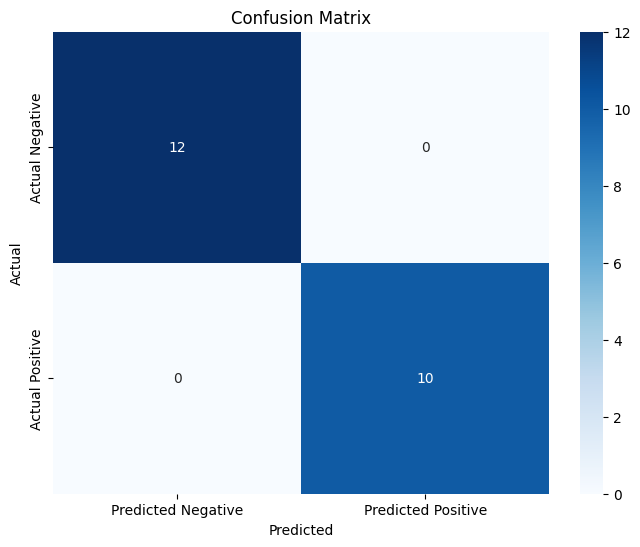

In [55]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy}")

# Make predictions
# Predict the class labels for the test set
predictions = (model.predict(X_test) > 0.5).astype("int32")

# Calculate evaluation metrics:
# Compute accuracy, precision, recall, F1 score, and ROC AUC score
accuracy_score_val = accuracy_score(y_test, predictions)
precision_score_val = precision_score(y_test, predictions)
recall_score_val = recall_score(y_test, predictions)
f1_score_val = f1_score(y_test, predictions)
roc_auc_score_val = roc_auc_score(y_test, model.predict(X_test))

print(f"Accuracy Score: {accuracy_score_val}")
print(f"Precision Score: {precision_score_val}")
print(f"Recall Score: {recall_score_val}")
print(f"F1 Score: {f1_score_val}")
print(f"ROC AUC Score: {roc_auc_score_val}")


# Plot the confusion matrix to visualize model performance
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

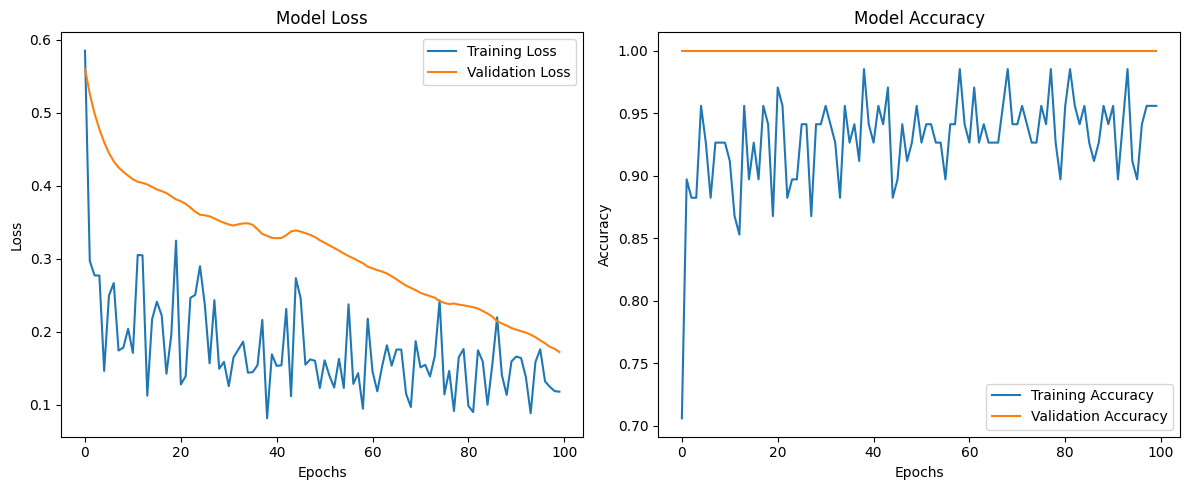

In [56]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
def plot_training_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_training_history(history)


Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9511 - loss: 0.1617 - val_accuracy: 1.0000 - val_loss: 0.1680 - learning_rate: 2.0000e-04
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9584 - loss: 0.1116 - val_accuracy: 1.0000 - val_loss: 0.1657 - learning_rate: 2.0000e-04
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9584 - loss: 0.1020 - val_accuracy: 1.0000 - val_loss: 0.1640 - learning_rate: 2.0000e-04
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9506 - loss: 0.1053 - val_accuracy: 1.0000 - val_loss: 0.1614 - learning_rate: 2.0000e-04
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9472 - loss: 0.1363 - val_accuracy: 1.0000 - val_loss: 0.1591 - learning_rate: 2.0000e-04
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9809 - loss: 0.0997 - val_accuracy: 1.0000 - val_loss: 0.1574 - learning_rate: 2.0000e-04
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9697 - loss:

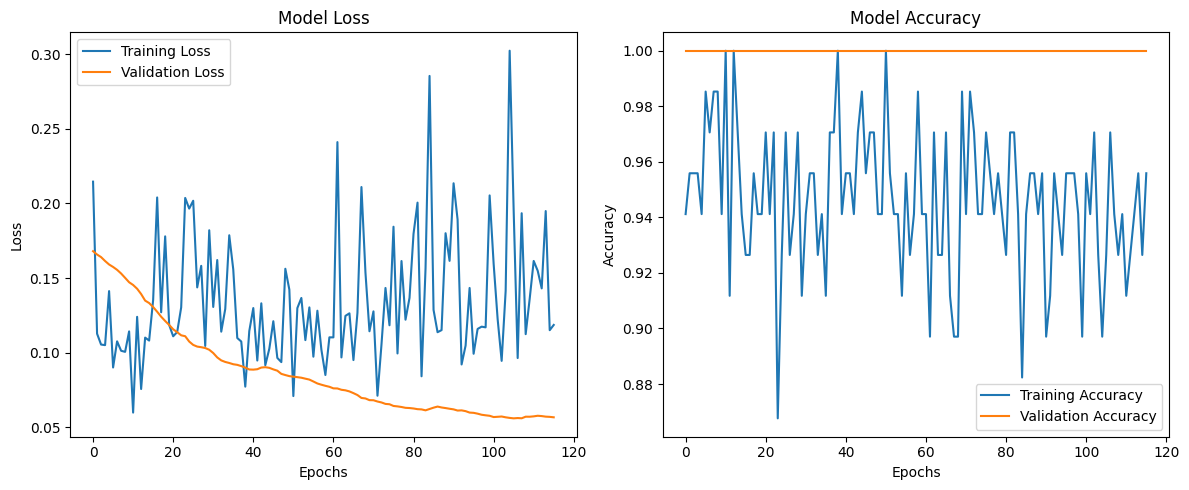

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9545 - loss: 0.0665
Accuracy on test data: 0.9545454382896423
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Accuracy Score: 0.9545454545454546
Precision Score: 1.0
Recall Score: 0.9
F1 Score: 0.9473684210526315
ROC AUC Score: 1.0


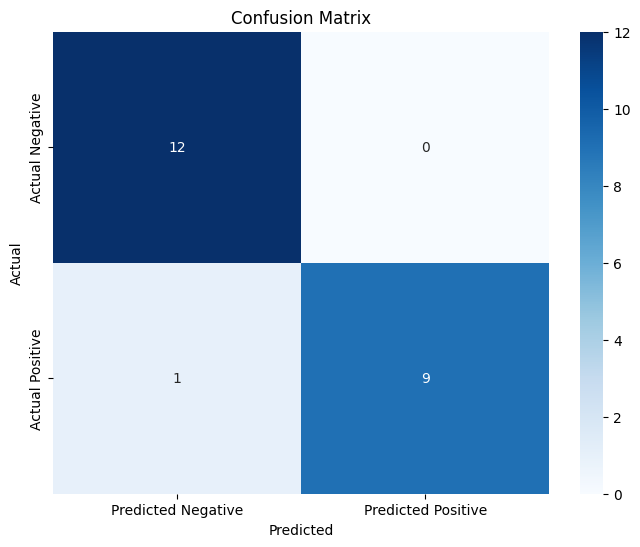

In [57]:
# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with the callbacks
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

plot_training_history(history)


# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy}")

# Make predictions
# Predict the class labels for the test set
predictions = (model.predict(X_test) > 0.5).astype("int32")

# Calculate evaluation metrics:
# Compute accuracy, precision, recall, F1 score, and ROC AUC score
accuracy_score_val = accuracy_score(y_test, predictions)
precision_score_val = precision_score(y_test, predictions)
recall_score_val = recall_score(y_test, predictions)
f1_score_val = f1_score(y_test, predictions)
roc_auc_score_val = roc_auc_score(y_test, model.predict(X_test))

print(f"Accuracy Score: {accuracy_score_val}")
print(f"Precision Score: {precision_score_val}")
print(f"Recall Score: {recall_score_val}")
print(f"F1 Score: {f1_score_val}")
print(f"ROC AUC Score: {roc_auc_score_val}")


# Plot the confusion matrix to visualize model performance
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [58]:
!pip install optuna --q

In [ ]:
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# add more tunnable paramebers


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize data
# Standardize features to have zero mean and unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model creation function
def create_model(trial):
    model = Sequential()
    model.add(Dense(units=trial.suggest_int('units_1', 32, 256), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_1', 0.2, 0.5)))

    for i in range(trial.suggest_int('n_layers', 1, 3)):
        model.add(Dense(units=trial.suggest_int(f'units_{i+2}', 16, 128), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(trial.suggest_float(f'dropout_{i+2}', 0.2, 0.5)))

    model.add(Dense(1, activation='sigmoid'))

    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    model.compile(optimizer=optimizer_name, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define the objective function for Optuna
def objective(trial):
    # Generate the model
    model = create_model(trial)

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=trial.suggest_categorical('batch_size', [16, 32, 64]),
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # Evaluate the model on test data
    predictions = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, model.predict(X_test))

    # Log the metrics
    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("f1", f1)
    trial.set_user_attr("roc_auc", roc_auc)

    return accuracy  # Objective to maximize

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, timeout=600)

# Get the best trial
best_trial = study.best_trial

# Print the best hyperparameters and metrics
best_hyperparameters = best_trial.params
accuracy = best_trial.user_attrs["accuracy"]
precision = best_trial.user_attrs["precision"]
recall = best_trial.user_attrs["recall"]
f1 = best_trial.user_attrs["f1"]
roc_auc = best_trial.user_attrs["roc_auc"]

print("Best Hyperparameters:", best_hyperparameters)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

# Plot the confusion matrix for the best model
best_model = create_model(best_trial)
best_model.fit(X_train, y_train, epochs=200, batch_size=best_hyperparameters['batch_size'], validation_split=0.2, verbose=0)
predictions = (best_model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


[I 2025-03-03 23:35:03,897] A new study created in memory with name: no-name-563fc8dc-1f7c-4d33-9224-0547b9b73710
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[I 2025-03-03 23:35:32,709] Trial 0 finished with value: 0.9545454545454546 and parameters: {'units_1': 101, 'dropout_1': 0.28522779577919954, 'n_layers': 1, 'units_2': 43, 'dropout_2': 0.45786028970896886, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 0 with value: 0.9545454545454546.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


[I 2025-03-03 23:35:43,701] Trial 1 finished with value: 0.9545454545454546 and parameters: {'units_1': 58, 'dropout_1': 0.26539102974092665, 'n_layers': 3, 'units_2': 41, 'dropout_2': 0.34402773033529066, 'units_3': 90, 'dropout_3': 0.2521592213531585, 'units_4': 50, 'dropout_4': 0.43587732968734033, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 0 with value: 0.9545454545454546.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[I 2025-03-03 23:36:08,932] Trial 2 finished with value: 0.9545454545454546 and parameters: {'units_1': 208, 'dropout_1': 0.2088077209386171, 'n_layers': 2, 'units_2': 101, 'dropout_2': 0.26565741541114696, 'units_3': 34, 'dropout_3': 0.4219645556207755, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 0 with value: 0.9545454545454546.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop

# Define the model creation function with more tunable parameters
def create_model(trial):
    model = Sequential()
    model.add(Dense(units=trial.suggest_int('units_1', 32, 256), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_1', 0.2, 0.5)))

    for i in range(trial.suggest_int('n_layers', 1, 3)):
        model.add(Dense(units=trial.suggest_int(f'units_{i+2}', 16, 128), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(trial.suggest_float(f'dropout_{i+2}', 0.2, 0.5)))

    model.add(Dense(1, activation='sigmoid'))

    # Suggest learning rate and optimizer
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define the objective function for Optuna
def objective(trial):
    # Generate the model
    model = create_model(trial)

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=trial.suggest_categorical('batch_size', [16, 32, 64]),
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # Evaluate the model on test data
    predictions = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, model.predict(X_test))

    # Log the metrics
    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("f1", f1)
    trial.set_user_attr("roc_auc", roc_auc)

    return accuracy  # Objective to maximize

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, timeout=600)

# Get the best trial
best_trial = study.best_trial

# Print the best hyperparameters and metrics
best_hyperparameters = best_trial.params
accuracy = best_trial.user_attrs["accuracy"]
precision = best_trial.user_attrs["precision"]
recall = best_trial.user_attrs["recall"]
f1 = best_trial.user_attrs["f1"]
roc_auc = best_trial.user_attrs["roc_auc"]

print("Best Hyperparameters:", best_hyperparameters)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

# Plot the confusion matrix for the best model
best_model = create_model(best_trial)
best_model.fit(X_train, y_train, epochs=200, batch_size=best_hyperparameters['batch_size'], validation_split=0.2, verbose=0)
predictions = (best_model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
